Cleaning and Counting
==================

At the end of the last chapter, we caught a glimpse of the complexities involved in working with textual data. Text 
is incredibly unruly. It presents a number of challenges -- which stem as much from general truths about linguistic 
phenomena as they do from the idiosyncracies of data representation -- that we'll need to address so that we may 
formalize text in a computationally-tractable manner.

As we've also seen, once we've formalized textual data, a key way we can start to gain some insight about that data 
is by counting words. Nearly all methods in text analytics begin by counting the number of times a word occurs and 
taking note of the context in which that word occurs. With these two pieces of information, **counts** and 
**context**, we can identify relationships among words and, on this basis, formulate interpretations about the texts we're studying.

This chapter, then, will discuss how to wrangle the messiness of text in a way that will let us start counting. 
We'll continue with our single text file (Mary Shelley's _Frankenstein_) and learn how to prepare text so as to 
generate valuable metrics about the words within it. Later workshops will build on what we've learned here by 
applying those metrics to multiple texts.

```{admonition} Learning Objectives
By the end of this workshop, you will be able to:

+ Clean textual data with a variety of processes
+ Recognize how these processes change the findings of text analysis
+ Explain why you might choose to do some cleaning steps but not others
+ Implement preliminary counting operations on cleaned data
+ Use a statistical measure (pointwise mutual information) to measure the uniqueness of phrases
```

Text Cleaning: Basics
-------------------------

To begin: think back to the end of the last chapter. There, we discussed a few differences between how computers 
represent and process textual data and our own way of reading. One of the key differences between these two poles 
involves details like spelling or capitalization. For us, the _meaning_ of text tends to cut across these details. 
But they make all the difference in how computers track information. Accordingly, if we want to work at a higher 
order of meaning, not just character sequences, we'll need to eliminate as many variances as possible in textual 
data.

First and foremost, we'll need to **clean** our text, removing things like punctuation and handling variances in 
word casing, even spelling. This entire process will happen in steps. Typically, they include:

1. Resolving word cases
2. Removing punctuation
3. Removing numbers
4. Removing extra whitespaces
5. Removing "stop words"

Note however that _there is no pre-set way to clean text_. The steps you need to perform all depend on your data 
and the questions you have about it. We'll walk through each of these steps below and, along the way, compare how 
they alter the original text to show why you might (or might not) implement them.

To make these comparisons, let's first load in _Frankenstein_.

In [1]:
with open("data/shelley_frankenstein.txt", 'r') as f:
    frankenstein = f.read()

We'll also define a simple function to count words. This will help us quickly check the results of a cleaning step.

```{tip}
Using `set()` in conjunction with a dictionary will allow us to pre-define the vocabulary space for which we need 
to generate counts. This removes the need to perform the `if...else` check from earlier.
```

In [2]:
def count_words(doc):
    doc = doc.split()
    word_counts = dict.fromkeys(set(doc), 0)
    for word in doc:
        word_counts[word] += 1
        
    return word_counts

Using this function, let's store the original number of unique words we generated from _Frankenstein_.

In [3]:
original_counts = count_words(frankenstein)
n_unique_original = len(original_counts)
print("Original number of unique words:", n_unique_original)

Original number of unique words: 11590


### Case normalization

The first step in cleaning is straightforward. Since our computer treats capitalized and lowercase letters as two 
different things, we'll need to collapse them together. This will eliminate problems like "the"/"The" and 
"letter"/"Letter." It's standard to change all letters to their lowercase forms.

In [4]:
cleaned = frankenstein.lower()

This should reduce the number of unique words in the novel. Let's check.

In [5]:
cleaned_counts = count_words(cleaned)
n_unique_words = len(cleaned_counts)

print(
    "Unique words:", n_unique_words, "\n"
    "Difference in word counts between our original count and the lowercase count:", 
    n_unique_original - n_unique_words
)

Unique words: 11219 
Difference in word counts between our original count and the lowercase count: 371


Sanity check: are we going to face the same problems from before?

In [6]:
print(
    "Is 'Letter' in `normalized`?", ("Letter" in cleaned), "\n"
    "Number of times 'the' appears:", cleaned_counts['the']
)

Is 'Letter' in `normalized`? False 
Number of times 'the' appears: 4152


So far so good. In the above output, we can also see that "the" has become even more prominent in the counts: we 
found ~250 more instances of this word after changing its case (it was 3897 earlier).

### Removing punctuation

It's now time to tackle punctuation. This step is a bit trickier, and typically it involves a lot of going back and 
forth between inspecting the original text and the output. This is because punctuation marks have different uses, 
so they can't all be handled in the same way.

Consider the following string:

In [7]:
s = "I'm a self-taught programmer."

```{margin} Want to practice regex?
[regex101] offers an interactive regex viewer with lots of explanations.

[regex101]: https://regex101.com/
```

It seems most sensible to remove punctuation with some combination of [regular expressions], or "regex," and the 
`re.sub()` function (which substitutes a regex sequence for something else). For example, we could use regex to 
identify anything that is _not_ (`^`) a word (`\w`) or a space (`\s`) and remove it.

That would look like this:

[regular expressions]: https://en.wikipedia.org/wiki/Regular_expression

In [8]:
import re

print(re.sub(r"[^\w\s]", "", s))

Im a selftaught programmer


This method has some advantages. For example, it sticks the _m_ in "I'm" back to the _I_. While this isn't perfect, 
as long as we remember that, whenever we see "Im," we mean "I'm," it's doable -- and it's better than the 
alternative: had we replaced punctuation with a space, we would have "I m." When split apart, those two letters 
would be much harder to piece back together. 

That said, this method also sticks "self" and "taught" together, which we don't want. It would be better to 
separate those two words than to create a new one altogether. Ultimately, this is a **tokenization** question: what 
do we define as acceptable tokens in our data, and how are we going to create those tokens? If you're interested in 
studying phrases that are hyphenated, you might not want to do any of this and simply leave the hyphens as they 
are.

In our case, we'll be taking them out. The best way to handle different punctuation conventions is to process 
punctuation marks in stages. First, remove hyphens, then remove other punctuation marks.

In [9]:
s = re.sub(r"-", " ", s)
s = re.sub(r"[^\w\s]", "", s)
print(s)

Im a self taught programmer


Let's use this same logic on `cleaned`. Note here that we're actually going to use two different kinds of 
hyphens, the en dash (-) and the em dash (—). They look very similar in plain text, but they have diferent 
character codes, and typesetters often use the latter when printing things like dates.

In [10]:
cleaned = re.sub(r"[-]|[—]", " ", cleaned)
cleaned = re.sub(r"[^\w\s]", "", cleaned)

Let's take a look.

In [11]:
print(cleaned[:353])

letter 1

_to mrs saville england_


st petersburgh dec 11th 17 


you will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such evil
forebodings i arrived here yesterday and my first task is to assure
my dear sister of my welfare and increasing confidence in the success
of my undertaking


That's coming along nicely, but why didn't those underscores get removed? Well, regex standards class underscores 
(or "lowlines") as word characters, meaning they class these characters along with the alphabet and numbers, 
rather than punctuation. So when we used `^\w` to find anything that isn't a word, this saved underscores from the 
chopping block.

To complete our punctuation removal, then, we'll remove these characters as well.

In [12]:
cleaned = re.sub(r"_", "", cleaned)

```{tip}
If you didn't want to do this separately, you could always include underscores in your code for handling hyphens. 
That said, punctuation removal is almost always a multi-step process, the honing of which involves multiple 
iterations. If you're interested to learn more, Laura Turner O'Hara has a [tutorial] on using regex to clean dirty 
OCR, which offers a particularly good example of how extended the process of punctuation removal can become.

[tutorial]: https://programminghistorian.org/en/lessons/cleaning-ocrd-text-with-regular-expressions
```

### Removing numbers

With our punctuation removed, we can turn our attention to numbers. They should present less of a problem. While 
our regex method above ended up keeping them around, we can remove them by simply finding characters 0-9 and 
replacing them with a blank.

In [13]:
cleaned = re.sub(r"[0-9]", "", cleaned)

Now that we've removed punctuation and numbers, we'll see a significant decrease in our unique word counts. This is 
because of the way our computers were handling word differences: remember that "letter;" and "letter" were counted separately before. Likewise, our computers were counting spans of digits as words. But with all that removed, we're 
left with only words.

In [14]:
cleaned_counts = count_words(cleaned)
n_unique_words = len(cleaned_counts)

print("Number of unique words after removing punctuation and numbers:", n_unique_words)

Number of unique words after removing punctuation and numbers: 6992


That's nearly a 40% reduction in the number of unique words!

### Text formatting

Our punctuation and number removal process introduced a lot of extra spaces into the text. Look at the first few 
lines, as an example: 

In [15]:
cleaned[:76]

'letter \n\nto mrs saville england\n\n\nst petersburgh dec th  \n\n\nyou will rejoice'

We'll need to remove those, along with things like newlines (`\n`) and tabs (`\t`). There are regex patterns for 
doing so, but Python's `split()` very usefully captures any whitespace characters, not just single spaces between 
words (in fact, the function we defined above, `count_words()`, has been doing this all along). So tokenizing our 
text as before will also take care of this step.

In [16]:
cleaned = cleaned.split()

And with that, we are back to the list representation of _Frankenstein_ that we worked with in the last chapter -- 
but this time, our metrics are much more robust. Let's store `cleaned` in a `Pandas` series so we can quickly 
count and plot the remaining words. We run `value_counts()` on the series to get our counts.

In [17]:
import pandas as pd

cleaned_counts = pd.Series(cleaned).value_counts()
pd.DataFrame(cleaned_counts, columns = ['COUNT']).head(25)

,COUNT
the,4194
and,2976
i,2850
of,2642
to,2094
my,1776
a,1391
in,1129
was,1021
that,1017


### Removing stop words

With the first few steps of our text cleaning done, we can take a closer look at the output. Inspecting the 25-most 
frequent words in _Frankenstein_ shows a pattern: nearly all of them are what we call **deictics**, or words that 
are highly dependent on the contexts in which they appear. We use these constantly to refer to specific times, 
places, and persons -- indeed, they're the very sinew of language, and their high frequency counts reflect this.

#### Words with high occurence

We can see the full extent to which we rely on these kinds of words if we plot our counts.

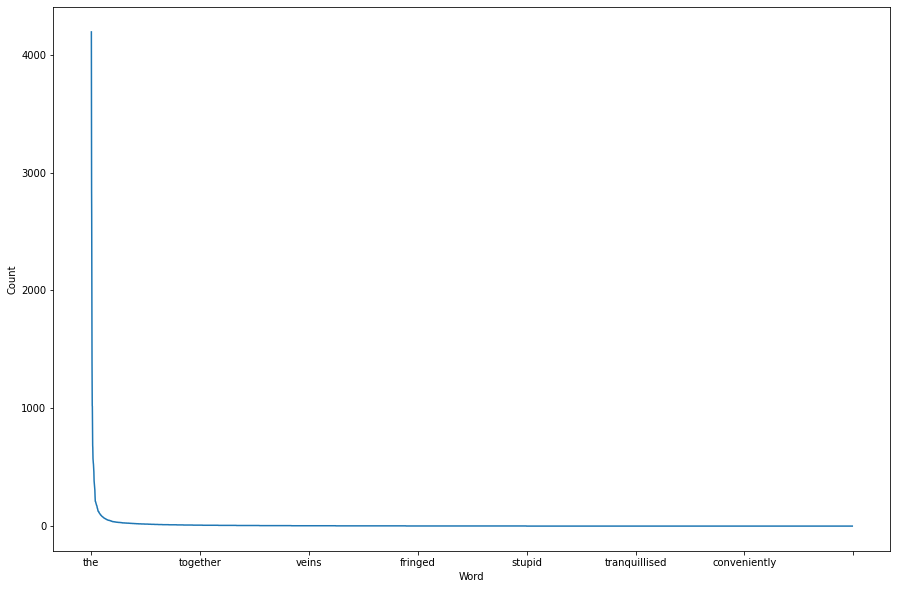

In [18]:
cleaned_counts.plot(figsize = (15, 10), ylabel = "Count", xlabel = "Word");

See that giant drop? Let's look at the 200-most frequent words and sample more words from the series index (which 
is the x axis). We'll put this code into a function, as we'll be looking at a number of graphs in this section.

```{margin} How to sample xticks:
Define a range of values from `0` to `n` (in this case, `n` will be `n_words`). Set the step count to your desired 
granularity (here we use `5`).
```

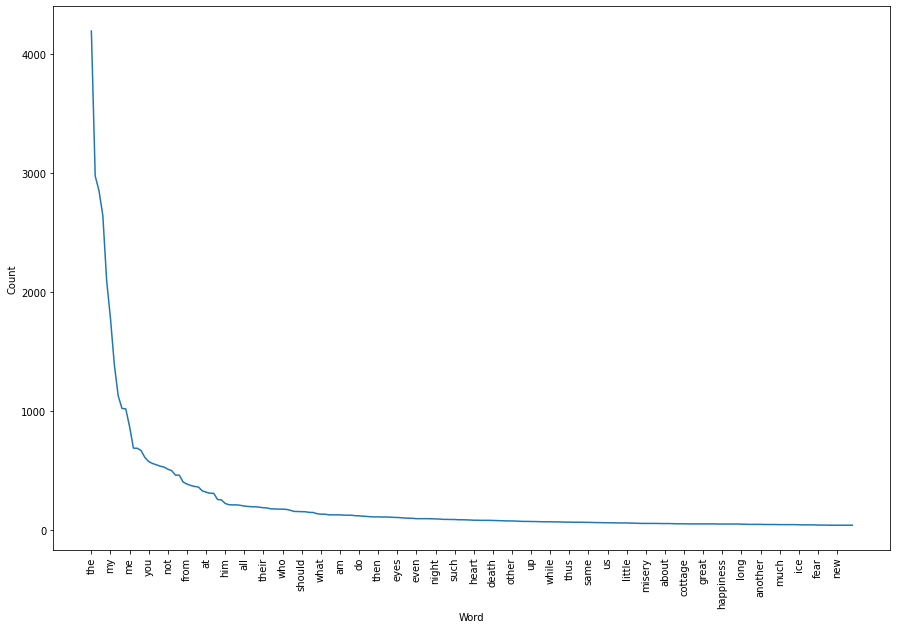

In [19]:
def plot_counts(word_counts, n_words=200, label_sample=5):    
    xticks_sample = range(0, n_words, label_sample)
    
    word_counts[:n_words].plot(
        figsize = (15, 10), 
        ylabel = "Count", 
        xlabel = "Word",
        xticks = xticks_sample,
        rot = 90
    );

plot_counts(cleaned_counts, n_words=200, label_sample=5)

```{margin} Further context:
The phenomenon we are discussing here is describable in terms of [Zipf's law], which states that, for certain types 
of data, the rank-frequency distribution is an inverse relation. That is, the top-most frequent element in the data 
will occur twice as often as the second-most frequent element, which will in turn occur twice as often as the 
third-most frequent element, etc.

[Zipf's law]: https://en.wikipedia.org/wiki/Zipf's_law
```

Only a few non-deictic words appear in the first half of this graph -- "eyes," "night," "death," for example. All 
else are words like "my," "from," "their," etc. And all of these words have screamingly high frequency counts. In 
fact, the 50-most frequent words in _Frankenstein_ comprise nearly 50% of the total number of words in the novel!

In [20]:
top_fifty_sum = cleaned_counts[:50].sum()
total_word_sum = cleaned_counts.sum()

print(
    f"Total percentage of 50-most frequent words: {top_fifty_sum / total_word_sum:.02f}%"
)

Total percentage of 50-most frequent words: 0.48%


The problem here is that, even though these highly-occurrent words help us say what we mean, they paradoxically 
don't seem to have much meaning in and of themselves. What can we determine about the word "it" without some kind 
of point of reference? How meaningful is "the"? These words are so common and so context-dependent that it's 
difficult to find much to say about them in and of themselves. Worse still, every novel we put through the above 
analyses is going to have a very similar distribution in terms -- they're just a general fact of language.

If we wanted, then, to surface what _Frankenstein_ is about, we'll need to handle these words. The most common way 
to do this is to simply remove them, or **stop** them out. But how do we know which **stop words** to remove?

#### Defining a stop list

The answer to this comes in two parts. First, compiling various **stop lists** has been an ongoing research area in 
natural language processing (NLP) since the emergence of information retrieval in the 1950s. There are a few 
popular ones, like the Buckley-Salton list or the Brown list, which capture many of the words we'd think to remove: 
"the," "do," "as," etc. Popular NLP packages like `nltk` and `gensim` even come preloaded with generalized lists, 
which you can quickly load.

In [21]:
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS

nltk_stopwords = stopwords.words('english')
gensim_stopwords = list(STOPWORDS)

print(
    "Number of entries in `ntlk` stop list:", len(nltk_stopwords),
    "\nNumber of entries in `gensim` stop list:", len(gensim_stopwords)
)

Number of entries in `ntlk` stop list: 179 
Number of entries in `gensim` stop list: 337


There are, however, substantial differences between stop lists, and you should carefully consider what they contain. Consider, for example, some of the stranger entries in the `gensim` stop list. While it contains the usual 
suspects:

In [22]:
for word in ['the', 'do', 'and']:
    print(f"{word:<3} in `gensim` stop list: {word in gensim_stopwords}")

the in `gensim` stop list: True
do  in `gensim` stop list: True
and in `gensim` stop list: True


...it also contains words like "computer," "empty," and "thick":

In [23]:
for word in ['computer', 'empty', 'thick']:
    print(f"{word:<8} in `gensim` stop list: {word in gensim_stopwords}")

computer in `gensim` stop list: True
empty    in `gensim` stop list: True
thick    in `gensim` stop list: True


"Computer" isn't likely to turn up in _Frankenstein_, but "thick" comes up several times in the novel. We can see 
these instances if we return to `cleaned`, which stores the novel in a list:

```{margin} What we're doing here:
First, use list comprehension to find the index positions of every instance of "thick."

Then, for each of those index positions:
+ Get the two words before the index (`start_span`) and the two words after it (`end_span`)
+ Index `cleaned` with those start and end points
+ Join the indexed selection into a string and print
```

In [24]:
idx_list = [idx for idx, word in enumerate(cleaned) if word == 'thick']

for idx in idx_list:
    start_span, end_span = idx - 2, idx + 3
    span = cleaned[start_span : end_span]
    print(f"{idx:>5} {' '.join(span)}")

 2902 a very thick fog we
10157 into the thick of life
29042 torrents and thick mists hid
29370 curling in thick wreaths around
36291 with a thick black veil
43328 in some thick underwood determining
56000 by a thick cloud and


This output brings us to the second, and more important part of the answer from above: **removing stop words 
depends on your texts and your research question(s)**. We're looking at a novel -- and a gothic novel at that. The 
kinds of questions we could ask about this novel might have to do with _tone_ or _style_, _word choice_, even 
_description_. In that sense, we definitely want to hold on to words like "thick" and "empty." But in other texts, 
or with other research questions, that might not be the case. A good stop list, then, is application-specific; you 
may in fact find yourself adding _additional_ words to stop lists, depending on what you're analyzing.

That all said, there are a broad set of NLP tasks that can really depend on keeping stop words in your text. These are tasks that fall under what's called **part-of-speech** tagging: they rely on stop words to parse the 
grammatical structure of text. Below, we will discuss one such example of these tasks, though for now, we'll go 
ahead with a stop list to demonstrate the result.

For our purposes, the more conservative `nltk` list will suffice. Note that it's also customary to remove any 
two-character words when we're applying stop words (this prevents us from seeing things like "st," or street). We 
will save the result of stopping out this list's words in a new variable, `stopped_counts`.

In [25]:
to_remove = cleaned_counts.index.isin(nltk_stopwords)
stopped_counts = cleaned_counts[~to_remove]
stopped_counts = stopped_counts[stopped_counts.index.str.len() > 2]

````{tip}
Because we were already working in `Pandas`, we're using a series subset to do this, but you could just as easily 
remove stop words with list comprehension. For example:

```{code}
[word for word in cleaned if (word not in nltk_stopwords) and (len(word) > 2)]
```
````

With our stop words removed, let's look at our total counts and then make another count plot.

In [26]:
print("Number of unique words after applying `nltk` stop words:", len(stopped_counts))

Number of unique words after applying `nltk` stop words: 6848


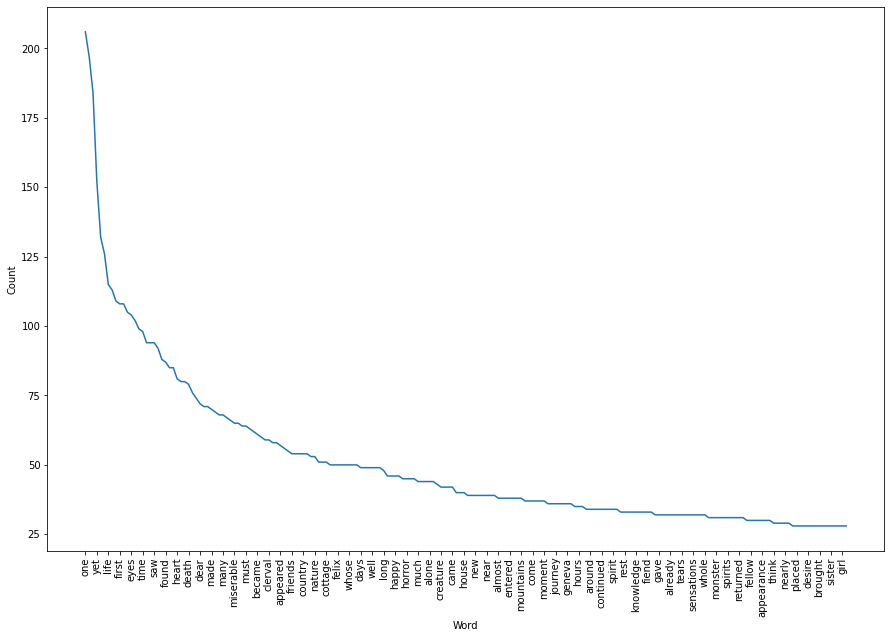

In [27]:
plot_counts(stopped_counts, n_words=200, label_sample=3)

#### Iteratively building stop lists

This is better, though there are still some words like "one" and "yet" that it would be best to remove. The list 
provided by `nltk` is good, but it's a little _too_ conservative, so we'll want to modify it. This is perfectly 
normal: like removing punctuation, getting a stop list just right is an iterative process that takes multiple 
tries.

To the `nltk` list, we'll add a set of stop words compiled by the developers of [Voyant], a text analysis portal. 
We can combine the two with a set union...

[Voyant]: https://www.voyant-tools.org/

In [28]:
with open("data/voyant_stoplist.txt", 'r') as f:
    voyant_stopwords = f.read().split()
    
custom_stopwords = set(nltk_stopwords).union(set(voyant_stopwords))

...refilter our counts series...

In [29]:
to_remove = cleaned_counts.index.isin(custom_stopwords)
stopped_counts = cleaned_counts[~to_remove]
stopped_counts = stopped_counts[stopped_counts.index.str.len() > 2]

print("Number of unique words after applying custom stop words:", len(stopped_counts))

Number of unique words after applying custom stop words: 6717


...and plot the results:

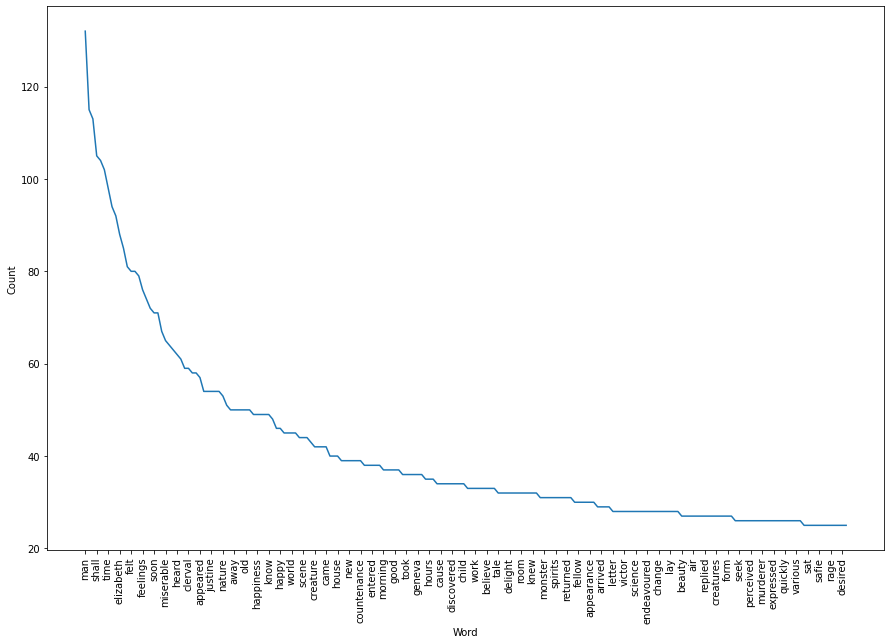

In [30]:
plot_counts(stopped_counts, n_words=200, label_sample=3)

Notice how, in each iteration through these stop lists, more and more "meaningful" words appear in our plot. From 
our current vantage, there seems to be much more we could learn about the specifics of _Frankenstein_ as a novel by 
examining words like "feelings," "nature," and "countenance," than if we stuck with "the," "of," and "to."

We'll quickly glance at the top 10 words in our unstopped text and our stopped text to see such differences more 
clearly. Here's unstopped:

In [31]:
pd.DataFrame(cleaned_counts[:10], columns = ['COUNT'])

,COUNT
the,4194
and,2976
i,2850
of,2642
to,2094
my,1776
a,1391
in,1129
was,1021
that,1017


And here's stopped:

In [32]:
pd.DataFrame(stopped_counts[:10], columns = ['COUNT'])

,COUNT
man,132
life,115
father,113
shall,105
eyes,104
said,102
time,98
saw,94
night,92
elizabeth,88


Text Cleaning: Advanced
-----------------------------

With our stop words removed, we could consider our text cleaning to be complete. But there are two more steps that 
we could do to further process our data: stemming and lemmatizing. We'll consider these separately from the steps 
above because they entail making significant changes to our data. Instead of simply removing pieces of irrelevant 
information, as with stop word removal, stemming and lemmatizing transform the forms of words.

### Stemming

**Stemming** algorithms are rule-based procedures that reduce words to their root forms. They cut down on the 
amount of morphological variance in your corpus, merging plurals into singulars, changing gerunds into static 
verbs, etc. This can be useful for a number of reasons. It cuts down on corpus size, which might be necessary when 
dealing with a large number of texts, or when building a fast search engine. Stemming also enacts a shift to a 
higher, more generalized form of words' meanings: instead of counting "have" and "having" as two different words 
with two different meanings, stemming would enable us to count them as a single entity, "have."

We can see this if we load the [Porter stemmer] from `nltk`. It's a class object, which we initialize by saving to 
a variable.

[Porter stemmer]: https://tartarus.org/martin/PorterStemmer/

In [33]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

Let's look at a few words.

In [34]:
to_stem = ['books', 'having', 'running', 'complicated', 'complicity', 'malleability']

for word in to_stem:
    print(f"{word:<12} => {stemmer.stem(word)}")

books        => book
having       => have
running      => run
complicated  => complic
complicity   => complic
malleability => malleabl


There's a lot of potential value in enacting these transformations with a stemmer. So far we haven't developed a 
method of handling plurals, which, it could be reasonably argued, should be considered the same as their singular 
variants; the stemmer handles this. Likewise, "having" to "have" is a useful transformation, and it would be 
difficult to come up with a custom algorithm that could handle the complexities of not only removing a gerund but 
replacing it with an _e_.

That said, the problem with stemming is that the process is rule-based and struggles with certain words. It can 
inadvertently merge what should be two separate words, as with "complicated" and "complicity" becoming "complic." 
And more, "complic," like "malleabl," isn't really a word. Rather, it represents a general idea, but one that a) 
is too baggy (it merges together two different words); and b) is harder to interpret in later analysis (how would 
we know what "complic" means when looking at word count distributions?).

### Lemmatizing

**Lemmatizing** textual data solves some of these problems, though at the cost of more complexity and more 
computational resources. Like stemming, lemmatization removes the inflectional forms of words. While it tends to be 
more conservative in its approach, it is better at avoiding lexical merges like "complicated" and "complicity" 
becoming "complic." More, the result of lemmatization is always a fully readable word, so no need to worry about 
trying to remember what "malleabl" means. If, say, you want to know something about the _theme_ or _topicality_ of 
a text, lemmatization would be a valuable step.

#### Part-of-speech tags and dependency parsing

Lemmatizers can do all this because they use the context provided by **part-of-speech tags** (POS tags). To get the 
best results, you need to pipe in a tag for each word, which the lemmatizer will use to make its decisions. In 
principle, this is easy enough to do. There are software libraries, including `nltk`, that will automatically 
assign POS tags through a process called **dependency parsing**. This proces analyzes the grammatical structure of 
a text string and tags words accordingly.

But now for the catch: to work at their best, _dependency parsers require both stop words and some punctuation 
marks_. Because of this, if you know you want to lemmatize your text, you're going to have to tag your text before 
doing other steps in the text cleaning process. Further, it's better to let an automatic tokenizer handle which 
pieces of punctuation to leave in and which ones to leave out. You'll still need to remove everything later on, but 
only after the dependency parser has done its work. The revised text cleaning steps would look like this:

1. Tokenize
2. Assign POS tags
3. Resolve word casing
4. Remove punctuation
5. Remove numbers
6. Remove extra whitespaces
7. Remove stopwords
8. Lemmatize

#### Sample lemmatization workflow

We won't do all of this for _Frankenstein_, but in the next session, when we start to use classification models to 
understand the differences between texts, we will. For now, we'll demonstrate an example of POS tagging using the 
`nltk` tokenizer in concert with its lemmatizer.

In [35]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

sample_string = """
The strong coffee, which I had after lunch, was $3. It kept me going the rest of the day.
"""
tokenized = word_tokenize(sample_string)

print("String after `nltk` tokenization:\n")
for entry in tokenized:
    print(entry)

String after `nltk` tokenization:

The
strong
coffee
,
which
I
had
after
lunch
,
was
$
3
.
It
kept
me
going
the
rest
of
the
day
.


Assigning POS tags:

```{margin} What does each tag mean?
`nltk` uses the Penn TreeBank tags, which you can find [here]. If the tagger receives a punctuation mark that isn't 
one of its special cases ("." or "$", for example), it simply repeats that mark.

[here]: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
```

In [36]:
tagged = nltk.pos_tag(tokenized)

print("Tagged tokens:\n")
for entry in tagged:
    print(entry)

Tagged tokens:

('The', 'DT')
('strong', 'JJ')
('coffee', 'NN')
(',', ',')
('which', 'WDT')
('I', 'PRP')
('had', 'VBD')
('after', 'IN')
('lunch', 'NN')
(',', ',')
('was', 'VBD')
('$', '$')
('3', 'CD')
('.', '.')
('It', 'PRP')
('kept', 'VBD')
('me', 'PRP')
('going', 'VBG')
('the', 'DT')
('rest', 'NN')
('of', 'IN')
('the', 'DT')
('day', 'NN')
('.', '.')


Note that `nltk.pos_tag()` returns a list of tuples. We'll put these in a dataframe and clean that way.

In [37]:
tagged = pd.DataFrame(tagged, columns = ['WORD', 'TAG'])
tagged

,WORD,TAG
0,The,DT
1,strong,JJ
2,coffee,NN
3,",",","
4,which,WDT
5,I,PRP
6,had,VBD
7,after,IN
8,lunch,NN
9,",",","


```{margin} Steps:
1. Reassign lowercase versions of all words
2. Subset `tagged` for all entries that aren't ",", "$", or "."
3. Subset `tagged` for all non-numeric numbers
4. Subset `tagged` for words not in stop words
```

In [38]:
tagged = tagged.assign(WORD = tagged['WORD'].str.lower())
tagged = tagged[~tagged['WORD'].isin([",", "$", "."])]
tagged = tagged[tagged['WORD'].str.isalpha()]
tagged = tagged[~tagged['WORD'].isin(custom_stopwords)]
tagged

,WORD,TAG
1,strong,JJ
2,coffee,NN
8,lunch,NN
15,kept,VBD
17,going,VBG
19,rest,NN
22,day,NN


Now we can load a lemmatizer -- and write a function to handle discrepancies between the tags we have up above and 
the tags that this lemmatizer expects. We did say this step is more complicated!

In [39]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 

lemmatizer = WordNetLemmatizer()

In [40]:
def convert_tag(tag):
    if tag.startswith('J'):
        tag = wordnet.ADJ
    elif tag.startswith('V'):
        tag = wordnet.VERB
    elif tag.startswith('N'):
        tag = wordnet.NOUN
    elif tag.startswith('R'):
        tag = wordnet.ADV
    else:
        tag = ''
    return tag

tagged = tagged.assign(NEW_TAG = tagged['TAG'].apply(convert_tag))
tagged

,WORD,TAG,NEW_TAG
1,strong,JJ,a
2,coffee,NN,n
8,lunch,NN,n
15,kept,VBD,v
17,going,VBG,v
19,rest,NN,n
22,day,NN,n


Finally, we can lemmatize.

```{margin} A bit of error handling
In case our tagger fails to assign tag, we can just send the word to our lemmatizer. The lemmatizer may have this 
word stored in its database, in which case it will make a change based on that. Otherwise, it just returns the 
word.
```

In [41]:
def lemmatize_word(word, new_tag):
    if new_tag != '':
        lemma = lemmatizer.lemmatize(word, pos = new_tag)
    else:
        lemma = lemmatizer.lemmatize(word)
    return lemma

tagged = tagged.assign(
    LEMMATIZED = tagged.apply(lambda row: lemmatize_word(row['WORD'], row['NEW_TAG']), axis=1)
)
tagged

,WORD,TAG,NEW_TAG,LEMMATIZED
1,strong,JJ,a,strong
2,coffee,NN,n,coffee
8,lunch,NN,n,lunch
15,kept,VBD,v,keep
17,going,VBG,v,go
19,rest,NN,n,rest
22,day,NN,n,day


This is a lot of work, but it does preserve important distinctions between words:

In [42]:
complic_dict = {'complicated': 'v', 'complicity': 'n'}

for word in complic_dict:
    word, tag = word, complic_dict[word]
    lemma = lemmatizer.lemmatize(word, pos = tag)
    print(f"{word:<11} => {lemma}")

complicated => complicate
complicity  => complicity


Chunking with N-Grams
----------------------------

With that, we are now done cleaning text. The last thing we'll discuss in this session is **chunking**. Chunking is 
closely related to tokenization. It involves breaking text into multi-token spans. This is useful if, for example, 
we want to find phrases in our data, or even entities. To wit: the processes above would dissolve "New York" into 
two separate tokens, and it would be very difficult to know how to reattach "new" and "york" from something like 
raw count metrics -- we may not even know this entity exists in the first place. Chunking, on the other hand, would 
lead us to identify it.

In this sense, it's often useful to count not only single words in our text, but continuous two word strings, even 
three. We call these strings **n-grams**, where _n_ is the number of tokens with which we chunk. "Bigrams" are 
two-token chunks. "Trigrams" are three-token chunks. Then, there are "4-grams," "5-grams," and so on. Technically, 
there's no real limit to the size of your n-grams, though their usefulness will depend on your data and your 
research questions.

To finish this chapter, we'll produce bigram counts on _Frankenstein_.

First, we'll return to `cleaned`, which holds the entire text in its original form:

In [43]:
cleaned[:10]

['letter',
 'to',
 'mrs',
 'saville',
 'england',
 'st',
 'petersburgh',
 'dec',
 'th',
 'you']

As before, let's load this into a series. Remember too that, while `cleaned` no longer contains punctuation, 
numbers, and extra whitespaces, it still contains stop words. We'll need to filter them out.

```{margin} Note:
Unlike in the code above, we do not need to use `.index` on our series because our words are stored in the series' 
values.
```

In [44]:
cleaned = pd.Series(cleaned)

to_remove = cleaned.isin(custom_stopwords)
stopped = cleaned[~to_remove]
stopped = stopped[stopped.str.len() > 2]

stopped[:10]

0          letter
2             mrs
3         saville
4         england
6     petersburgh
7             dec
11        rejoice
13           hear
16       disaster
18    accompanied
dtype: object

Once again, `nltk` has in-built functionality to help us with our chunking. There are a few options here, but since 
we want to get bigram counts, we'll use objects from `nltk`'s `collocations` module. `BigramAssocMeasures()` will 
generate our scores, while `BigramCollocationFinder()` will create our bigrams.

```{margin} Other options
`nltk` also has a `bigrams()` object that you can call with `nltk.bigrams()`. It returns an iterator of all 
bigrams, which is quite useful. That said, it's harder to use this object to produce valuable bigram metrics, as 
we'll do below.
```

In [45]:
from nltk import collocations

bigram_measures = collocations.BigramAssocMeasures()
bigram_finder = collocations.BigramCollocationFinder.from_words(stopped)

If we want to get the raw bigram counts (which `nltk` calls a "frequency distribution"), we use the `ngram_fd` 
method. That can be stored in a dataframe, which we'll sort by value.

In [46]:
freq = bigram_finder.ngram_fd

bigram_freq = pd.DataFrame(freq.keys(), columns = ['WORD', 'PAIR'])
bigram_freq = bigram_freq.set_index('WORD')
bigram_freq = bigram_freq.assign(VALUE = freq.values()).sort_values('VALUE', ascending = False)

bigram_freq.head(10)

,PAIR,VALUE
WORD,,
old,man,32
native,country,15
natural,philosophy,14
taken,place,13
fellow,creatures,12
dear,victor,10
young,man,9
short,time,9
long,time,9


Looks good! We can see some phrases peeking through. But while bigram counts provide us with information about 
frequently occuring phrases in our text, it's hard to know how _unique_ these phrases are. For example: "man" 
appears throughout the text, so it's likely to appear in a lot of bigrams; indeed, we can even see it appearing 
again in "young man." How, then, might we determine whether there's something unique about whether "old" and "man" 
consistently stick together?

One way we can do this is with a PMI, or **pointwise mutual information**, score. PMI measures the association 
strength of a pair of outcomes. In our case, the higher the score, the more likely a given bigram pair will be with 
respect to the other bigrams in which the two words of the present one appear.

We can get a PMI score for each bigram using the `score_ngrams` and `pmi` methods of our collocator and measurer, 
respectively. This will return a list of nested tuples, which will take a little work to coerce into a dataframe.

```{margin} Steps:
1. Make our dataframe; the result stores a tuple in the `BIGRAMS` column
2. Assign the first position of each tuple in `BIGRAMS` to `WORD`
3. Assign the second position of each tuple in `BIGRAMS` to `PAIR`
4. Remove `BIGRAMS`
5. Rearrange our columns
6. Set `WORDS` as our index
```

In [47]:
bigram_pmi = bigram_finder.score_ngrams(bigram_measures.pmi)

pmi_df = pd.DataFrame(bigram_pmi, columns = ['BIGRAMS', 'PMI'])
pmi_df = pmi_df.assign(
    WORD = pmi_df['BIGRAMS'].apply(lambda x: x[0]),
    PAIR = pmi_df['BIGRAMS'].apply(lambda x: x[1])
)

pmi_df = pmi_df.drop(columns = ['BIGRAMS'])
pmi_df = pmi_df[['WORD', 'PAIR', 'PMI']]
pmi_df = pmi_df.set_index('WORD')

Let's take a quick look at the distribution of these scores.

In [48]:
pmi_df.describe()

,PMI
count,29053.000000
mean,8.473590
std,2.608898
min,1.029961
25%,6.572605
50%,8.402680
75%,10.309571
max,14.894534


Here are the 10 bottom-most scoring bigrams:

In [49]:
pmi_df.tail(10)

,PAIR,PMI
WORD,,
said,father,1.401929
man,saw,1.295551
saw,man,1.295551
father,father,1.254176
life,father,1.228865
said,man,1.177714
man,eyes,1.149700
man,shall,1.135894
shall,man,1.135894


And here's a sampling of 25 bigrams with a PMI above 10.31 (bigrams above the 75th percentile):

In [50]:
pmi_df[pmi_df['PMI'] > 10.31].sample(25).sort_values('PMI', ascending = False)

,PAIR,PMI
WORD,,
pinnacle,pine,14.894534
enslaved,cæsar,14.894534
clock,indicated,14.894534
detect,punish,13.894534
accept,invitation,13.309571
forgive,unkindness,12.894534
incomplete,final,12.894534
common,projectors,12.572605
complained,wickedness,12.309571


Among the worst-scoring bigrams, we see words that are likely to be combined with many different words: "said," 
"man," "shall," etc. On the other hand, among the best-scoring bigrams, we see coherent entities and suggestive 
pairings. The latter especially begin to sketch out the specific qualities of Shelley's prose style.